# Laboratorio #3
Luis Pedro Pérez - 22008067

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso

from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OrdinalEncoder, RareLabelEncoder, CountFrequencyEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures

Se cargan los datos a la variable df y se extrae las dimensiones

In [2]:
df  = pd.read_csv("Lab3/train.csv", sep=",")
df_2= df.copy()
print("La dimensión del dataset es de:", df.shape)
df.head()

La dimensión del dataset es de: (14447, 11)


,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,9744,-121.65,36.77,15,2191,358.0,1150,330,4.7969,227500.0,<1H OCEAN
1,13893,-116.27,34.13,37,452,109.0,184,59,3.7292,65800.0,INLAND
2,18277,-122.07,37.34,35,1172,184.0,512,175,7.3561,500001.0,<1H OCEAN
3,16176,-122.39,37.74,52,126,24.0,37,27,10.2264,225000.0,NEAR BAY
4,8843,-118.38,34.09,28,4001,1352.0,1799,1220,2.5784,272900.0,<1H OCEAN


Se extraen los tipos de datos

In [3]:
df.dtypes

id                      int64
longitude             float64
latitude              float64
housing_median_age      int64
total_rooms             int64
total_bedrooms        float64
population              int64
households              int64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

Se extraen las columnas con valor NA

In [4]:
cols_con_na=[col for col in df.columns if (df[col].isnull().mean()>0)]
print(f"Se tienen {len(cols_con_na)} columnas con NA")
print(cols_con_na)
print("Los tipos de las columnas son:")
print(df[cols_con_na].dtypes)

Se tienen 1 columnas con NA
['total_bedrooms']
Los tipos de las columnas son:
total_bedrooms    float64
dtype: object


Se obtiene la proporción de faltantes en las columnas que tengan NA

In [5]:
prop_nan_per_col = df[cols_con_na].isnull().mean()
print(f"El total de faltantes para las columnas {cols_con_na}, es de: {prop_nan_per_col}")

El total de faltantes para las columnas ['total_bedrooms'], es de: total_bedrooms    0.009483
dtype: float64


Se procede a graficar la proporción de las columnas con faltantes

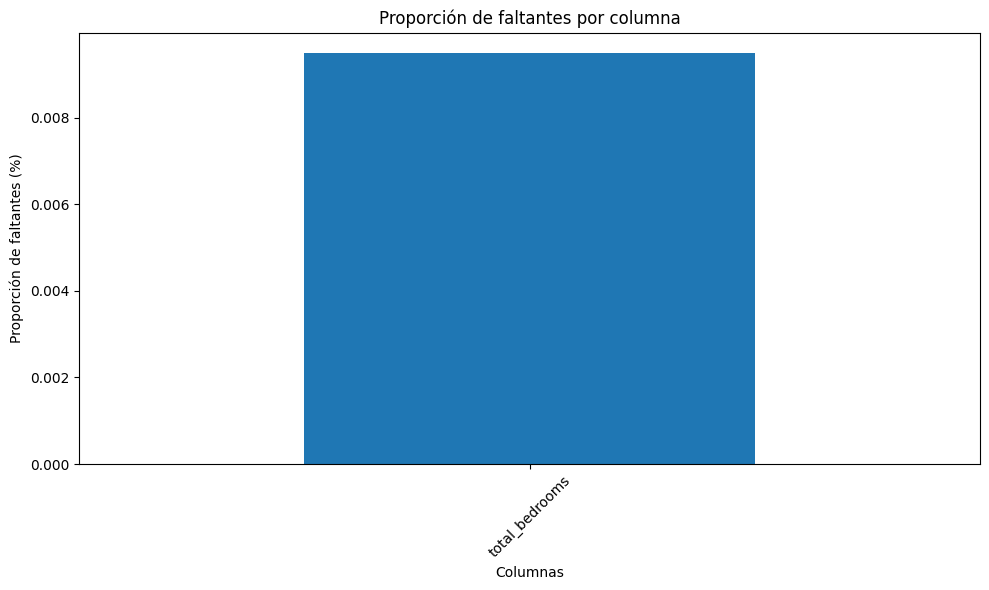

In [6]:
plt.figure(figsize=(10, 6))
prop_nan_per_col.plot(kind='bar')
plt.xlabel('Columnas')
plt.ylabel('Proporción de faltantes (%)')
plt.title('Proporción de faltantes por columna')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Imputación de datos

In [7]:
media= df['total_bedrooms'].mean()
mediana = df['total_bedrooms'].median()
print(f"Media: {media}")
print(f"Mediana: {mediana}")

Media: 537.7787561146051
Mediana: 433.0


In [8]:
df['total_bedrooms_mean'] = np.round(df['total_bedrooms'].fillna(media), 0)
df['total_bedrooms_median'] = np.round(df['total_bedrooms'].fillna(mediana), 0)
df['total_bedrooms_na'] = df['total_bedrooms'].dropna()

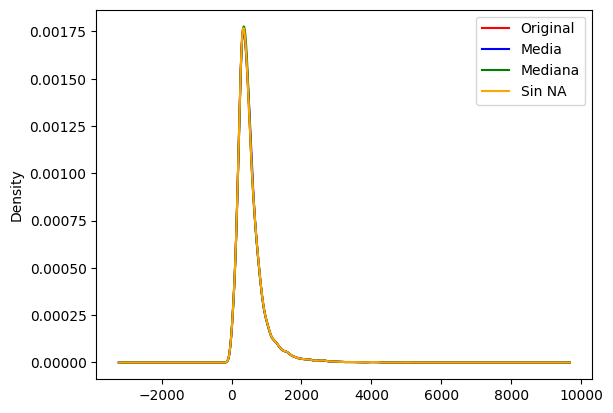

In [9]:
fig= plt.figure()
ax = fig.add_subplot(111)

df['total_bedrooms'].plot.density(color='red', label= 'Original')
df['total_bedrooms_mean'].plot.density(color='blue', label= "Media")
df['total_bedrooms_median'].plot.density(color='green', label= "Mediana")
df['total_bedrooms_na'].plot.density(color='orange',label = 'Sin NA')
ax.legend()

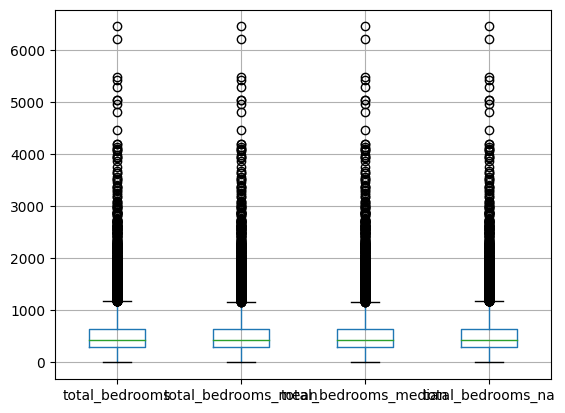

In [10]:
df[['total_bedrooms','total_bedrooms_mean', 'total_bedrooms_median', 'total_bedrooms_na']].boxplot()
plt.show()

Debido a que no hay distorción entre el uso de la media y la mediana, se utilizará la media para esta columna

In [11]:
df['total_bedrooms']=df['total_bedrooms_mean']
#Se procede a eliminar las columnas creadas
df.drop(['total_bedrooms_mean','total_bedrooms_median', 'total_bedrooms_na'],axis=1,inplace=True)

## Codificación categórica

In [12]:
def getCategoryVars(dataset):
    cat_colnames=[]
    colnames=dataset.columns
    for col in colnames:
        if(dataset[col].dtype=='object'):
            cat_colnames.append(col)
    return cat_colnames

In [13]:
cat_cols=getCategoryVars(df)
print(cat_cols)

['ocean_proximity']


Se procede a realizar el análisis para la codificación via One Hot Encoding

In [14]:
# Se toma de las columnas como máximo 3 categorías diferentes para hacer el One Hot Encoding
one_hot_encoding=[]

for i in cat_cols:
    if len(df.groupby(i).count())<=3:
        print("")
        print(df[i].value_counts().sort_values(ascending=False))
        one_hot_encoding.append(i)
    else:
        print(f"La columna posee un total de {len(df.groupby(i).count())}, por lo que no se puede usar One Hot encoding")
print(f"Las variables para One Hot Encoding son: {one_hot_encoding}")

La columna posee un total de 5, por lo que no se puede usar One Hot encoding
Las variables para One Hot Encoding son: []


Se procede a realizar el análisis para codificación por frecuencia

In [15]:
# Se obtienen las variables para realizar Frecuency encoding a aquellas que poseen mas de 3 categorías

freq_encoding=[]

for i in cat_cols:
    if len(df.groupby(i).count())>3:
        print("")
        print(df[i].value_counts().sort_values(ascending=False))
        freq_encoding.append(i)
print(f"Las variables para Frecuency Encoding son: {freq_encoding}")


<1H OCEAN     6384
INLAND        4577
NEAR OCEAN    1865
NEAR BAY      1619
ISLAND           2
Name: ocean_proximity, dtype: int64
Las variables para Frecuency Encoding son: ['ocean_proximity']


In [16]:
# Se crean los diccionarios con las frecuencias de cada variable para realizar el frecuency encoding

ocean_proximity_freq_mapper=(df['ocean_proximity'].value_counts().sort_values(ascending=False)).to_dict()

In [17]:
# Se mapean las frecuencias con el dataset

df['ocean_proximity_code']=df['ocean_proximity'].map(ocean_proximity_freq_mapper)

Se depura el dataset para dejar variables numéricas

In [18]:
#Se define la función para identificar las columnas y datos
def GetVarsNumeric(dataset):
    num_colsnames=[]
    columnas=dataset.columns

    for col in columnas:
        if((dataset[col].dtype=='int64') or (dataset[col].dtype=='float')) or (dataset[col].dtype=='uint8'):
            num_colsnames.append(col)
    return num_colsnames

In [19]:
num_cols=GetVarsNumeric(df)
print(num_cols)

['id', 'longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity_code']


Se crea dataset nuevo con columnas codificadas

In [20]:
df_cod= df[num_cols]
df_cod

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_code
0,9744,-121.65,36.77,15,2191,358.0,1150,330,4.7969,227500.0,6384
1,13893,-116.27,34.13,37,452,109.0,184,59,3.7292,65800.0,4577
2,18277,-122.07,37.34,35,1172,184.0,512,175,7.3561,500001.0,6384
3,16176,-122.39,37.74,52,126,24.0,37,27,10.2264,225000.0,1619
4,8843,-118.38,34.09,28,4001,1352.0,1799,1220,2.5784,272900.0,6384
...,...,...,...,...,...,...,...,...,...,...,...
14442,557,-122.25,37.77,43,4329,1110.0,2086,1053,2.9750,243400.0,1619
14443,16090,-122.48,37.71,43,3850,1018.0,1497,829,3.5296,400000.0,1865
14444,9083,-118.17,34.69,12,4881,803.0,2188,724,4.1667,171900.0,4577
14445,13138,-121.44,38.47,5,5666,1178.0,3139,1131,3.3608,108900.0,4577


## Feature Scaling

Se obtiene una descripción del dataset

In [21]:
df_cod.describe()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_code
count,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000
mean,10275.451997,-119.580422,35.642011,28.845435,2635.287534,537.780854,1425.171454,500.116772,3.863949,206873.687824,4693.277151
std,5957.136373,2.003511,2.135526,12.585221,2215.285809,421.997029,1123.733449,386.181946,1.892919,115263.889710,1833.712940
min,1.000000,-124.300000,32.540000,1.000000,2.000000,1.000000,6.000000,1.000000,0.499900,14999.000000,2.000000
25%,5139.500000,-121.805000,33.930000,18.000000,1444.000000,297.000000,786.000000,280.000000,2.567150,119600.000000,4577.000000
50%,10210.000000,-118.500000,34.260000,29.000000,2121.000000,436.000000,1163.000000,408.000000,3.535000,179700.000000,4577.000000
75%,15449.000000,-118.020000,37.720000,37.000000,3137.500000,644.000000,1722.000000,604.500000,4.722850,264600.000000,6384.000000
max,20640.000000,-114.310000,41.950000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000,6384.000000


Se define la función para extraer los dominios de las columnas de un dataset

In [22]:
continuas= []
discretas= []
categoricas= []
def getColumnTypes(dataset):
    # Descripción: Esta función extrae el tipo de dominio de las columnas de un dataset.
    # Entradas: Pandas dataframe
    # Salida: Tupla con arreglo que contiene nombres de las columnas 
    for col in dataset.columns:
        if((dataset[col].dtype =='int64') or (dataset[col].dtype == 'float64')):
            if(len(dataset[col].unique()) > 30):
                continuas.append(col)
            else:
                discretas.append(col)
        else:
            categoricas.append(col)
    return continuas, discretas, categoricas

Se clasifican las variables por tipo de dominio

In [23]:
continuas, discretas, categoricas= getColumnTypes(df_cod)
print(continuas)
print(discretas)
print(categoricas)

['id', 'longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
['ocean_proximity_code']
[]


Se extraen las variables que son contínuas y se genera un dataset

In [24]:
data_temp = df_cod.copy()[continuas]

In [25]:
scaler =  StandardScaler()
scaler.fit(data_temp) # calculamos información interna (parámetros) para transformaciones posteriores

data_scaled = scaler.transform(data_temp)
data_scaled = pd.DataFrame(data_scaled, columns=data_temp.columns)

In [26]:
round(data_scaled.describe(),2)

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00
mean,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.72,-2.36,-1.45,-2.21,-1.19,-1.27,-1.26,-1.29,-1.78,-1.66
25%,-0.86,-1.11,-0.80,-0.86,-0.54,-0.57,-0.57,-0.57,-0.69,-0.76
50%,-0.01,0.54,-0.65,0.01,-0.23,-0.24,-0.23,-0.24,-0.17,-0.24
75%,0.87,0.78,0.97,0.65,0.23,0.25,0.26,0.27,0.45,0.50
max,1.74,2.63,2.95,1.84,16.56,14.00,24.15,14.45,5.88,2.54


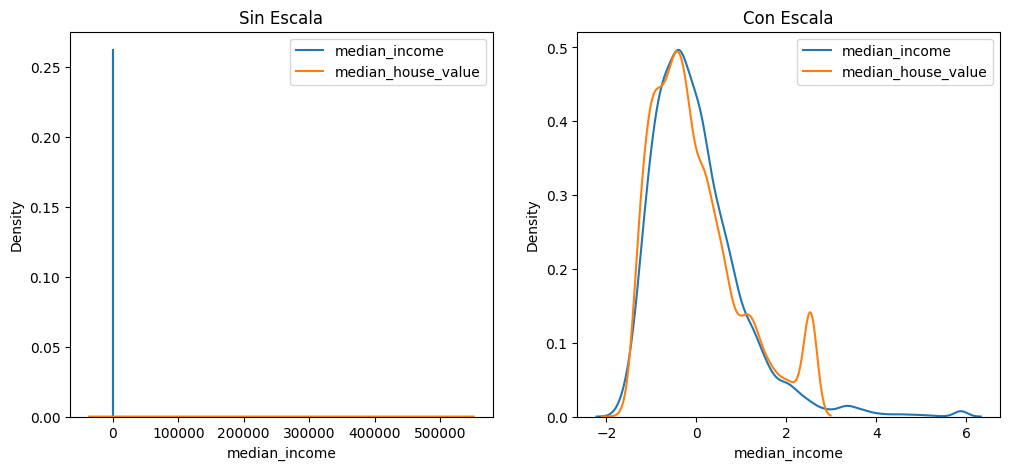

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

ax1.set_title("Sin Escala")
sns.kdeplot(data_temp['median_income'], ax=ax1, label="median_income")
sns.kdeplot(data_temp['median_house_value'], ax=ax1, label="median_house_value")

ax2.set_title("Con Escala")
sns.kdeplot(data_scaled['median_income'], ax=ax2, label="median_income")
sns.kdeplot(data_scaled['median_house_value'], ax=ax2, label="median_house_value")

ax1.legend()
ax2.legend()
plt.show()

## Configuración del Pipeline

In [47]:
df_2.columns

Index(['id', 'longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    df_2.drop(['id', 'longitude', 'latitude','median_house_value'], axis=1),
    df_2['median_house_value'],
    test_size=0.3,
    random_state=2023)

In [49]:

#Imputación de Variables Numéricas:
NUMERICAL_VARS_WITH_NA = ['total_bedrooms']

#Variables para codificación por frecuencia (no ordinal)
CATEGORICAL_VARS = ['ocean_proximity']

#Variables a utilzar en el entrenamiento
FEATURES = ['housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']

In [50]:
X_train = X_train[FEATURES]

### Construcción Pipeline

In [51]:
X_train

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1220,34,1723,279.0,617,252,6.7501,<1H OCEAN
6446,10,2980,585.0,1593,562,3.2850,<1H OCEAN
10521,39,2002,416.0,1166,395,1.7257,NEAR BAY
13367,32,1260,382.0,1434,342,2.0286,<1H OCEAN
4439,21,2630,446.0,1789,389,5.0543,<1H OCEAN
...,...,...,...,...,...,...,...
5852,25,3095,514.0,1251,507,5.5388,<1H OCEAN
6049,26,3141,670.0,1572,724,3.3472,<1H OCEAN
2743,21,1899,447.0,1133,391,1.8636,INLAND
5657,34,2231,545.0,1568,510,1.5217,INLAND


In [52]:
y_train = np.log(y_train)
y_test = np.log(y_test)

### Construcción del pipeline

In [53]:
house_value_pipeline = Pipeline([
    #=========== IMPUTACIONES ===============
    
    #1. Imputación de variables numéricas
    ('mean_imputation',
        MeanMedianImputer(imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA)
    ),

    #============= CODIFICACIÓN DE VARIABLES CATEGORICAS NOMINALES ==================
    
    ('categorical_encoder',
        CountFrequencyEncoder(encoding_method='frequency', variables=CATEGORICAL_VARS)
    ),
     #=============== SCALER ============
    ('scaler',
        MinMaxScaler()
    ),
    
    ('modelo_lasso', 
         Lasso(alpha=0.01, random_state=2023))
])

In [54]:
house_value_pipeline.fit(X_train, y_train)

Pipeline(steps=[('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['total_bedrooms'])),
                ('categorical_encoder',
                 CountFrequencyEncoder(encoding_method='frequency',
                                       variables=['ocean_proximity'])),
                ('scaler', MinMaxScaler()),
                ('modelo_lasso', Lasso(alpha=0.01, random_state=2023))])

Se generan los valores predecidos basados en los datos del dataset de prueba

In [55]:
preds = house_value_pipeline.predict(X_test)

Se obtiene el MSE

In [78]:
rmseTest = round(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(preds))),4)
print(f"El MSE es para el dataset de prueba es de: {rmseTest}, y el RMSE es de {round(rmseTest**0.5, 4)}")

El MSE es para el dataset de prueba es de: 97173.233, y el RMSE es de 311.7262


Se obtienen los valores mínimos y máximos

In [79]:
val_min = round(np.min(np.exp(y_train)),4)
val_max = round(np.max(np.exp(y_train)),4)
print(f"Para el MSE, el valor mínimo es: {val_min}, y el valor máximo es: {val_max}")
print(f"Mientras que para el RMSE, el valor mínimo es: {round(val_min**(1/2),4)}, y el valor máximo es: {round(val_max**(1/2),4)}")

Para el MSE, el valor mínimo es: 22500.0, y el valor máximo es: 500001.0
Mientras que para el RMSE, el valor mínimo es: 150.0, y el valor máximo es: 707.1075


Se valida la variación del MSE 

In [75]:
rmseTest / (val_max - val_min)

0.20350372669376607